In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KernelDensity
import pickle
import random

In [1]:
def prep_phase(bandwith, neuron_df, lick_df):
    """
    Calculate the Phase PDF for a spike train, using KDE.

    Parameters:
    - bandwith: bandwidth for the kde (see sklearn documentation)
    - neuron_df: dataframe with identifying information and 2000 1-ms bins of neural spiking information
        where 0 = no spike in that ms
              1 = spike in that ms
    - lick_df: dataframe with identifying information nad 2000 1-ms bins of lick information for a trial/stimuli combo
        where 0 = no lick at that time
              1 - lick at that time

    Returns:
    - The Phase PDF sampled for 1000 normalized ms
    """
    kde_scores = np.zeros(shape = (len(neuron_df['Taste'].unique()),1000))
    
    for taste in neuron_df['Taste'].unique():
        tn=neuron_df[(neuron_df['Taste'].isin([taste]))]
        tl=lick_df[(lick_df['Taste'].isin([taste]))]
        
        ty=split_data_Li(tn,tl)
        log_dens_scores = apply_kde(ty, bandwith)
        
        if len(neuron_df['Taste'].unique()) == 1:
            kde_scores[0,:] = log_dens_scores
        else:
            kde_scores[taste,:] = log_dens_scores
        
    return kde_scores  

def apply_kde(yvals, bw_size):
    # yvals: normalized spike trains
    # bw_size: bandwidth parameter for Kernel density estimation. choose via gridsearch.
    # takes in normalized spike trains and spits out the kernel density estimation result (PDF)
    
    #sum yvals rows into one vector
    ysum = np.sum(yvals, axis=0)
    vals = np.nonzero(ysum)
    kde_input = vals[0][:, np.newaxis]
    
    if kde_input.shape ==(0,1):
        # if we have no information on the phase (i.e. no spikes), make it a uniform dist (that integrates to one)
        distribution_height = 1 / (999)
        log_dens_scores = np.array([distribution_height] * 1000)
    else:
        kde = KernelDensity(kernel="gaussian", bandwidth=bw_size).fit(kde_input)
        all_x=np.array([i for i in range(1000)])[:, np.newaxis]
        scores = kde.score_samples(all_x)
        log_dens_scores = np.exp(scores)
    
    return log_dens_scores

#### Data pre-processing: 
Our data has already had some processing: binned in 1ms bins, keep data only for the 2s (2000ms) after stimulus introduction. There are no instances in which we had >1 fire/ms. We've also ensured that each stimuli is equally likely in the overall dataset (so, the number of trials per stimuli is constant), because this is one of the assumptions that we rely on for simplification of our probability calculations.

Our dataframes NeuronDF and LickDF have information in the following manner:
both dataframes have four columns of identifying information as the first four columns: Recording type (either lick or Neuron), Taste (integer value, corresponding to different stimuli), Neuron (unique integer value assigned to each seperate neuron), and Trial. 

Following these four columns, there are 2000 columns, each corresponding to a single 1ms bin. Entries will be either 0 or 1, corresponding to the absence (or presence) of a spike at that time (for NeuronDF. For LickDF, this corresponds to the absence or presence of a lick).

split_data_Li is a function that takes in the dataframes and returns an array of processed spike trains, where there is only 5 lick intervals of information, and now each lick interval has been normalized to be exactly 200ms.

In [ ]:
def split_data_Li(neuronDF, licksDF):
    # take in neuron spiking information and licking information, 
    # return array that contains 5 lick intervals (LI) of information, each normalized to 200ms
    
    yvals = np.zeros(shape=(len(licksDF),1000))
    for row in range(len(licksDF)):
        y = np.zeros(1000)
        
        l = np.array(licksDF.iloc[row, 4:]).astype(int)
        ltimes = np.nonzero(l)
        
        nfires = np.array(neuronDF.iloc[row, 4:]).astype(float)
        
        if len(ltimes[0]) >= 6:
            nfires = nfires[ltimes[0][0]:ltimes[0][5]]
            li_len = ltimes[0][5] - ltimes[0][0]
        else:
            nfires = nfires
            li_len = len(nfires)
        
        
        if sum(nfires) != 0.0:
        #tspikes tells you times of where spikes should fall
            n=np.nonzero(nfires)
            tspikes = np.array([nf/li_len for nf in n])
            tspikes = ((np.round(tspikes, decimals=3))*1000).astype(int)
        
            for i in tspikes[0]:
                if 0 <= i < 1000:
                    y[i] = 1.0
        
            yvals[row,:] = y
    
    return yvals

In [174]:
# open dataframes with our recording information in it
neuronDF =pd.read_pickle(
'C:/Users/nasha/OneDrive - Florida State University/TomRichard/Paper/dataFolder/NeuronDFnormTrialsTruncatedNOwater')
LickDF =pd.read_pickle(
'C:/Users/nasha/OneDrive - Florida State University/TomRichard/Paper/dataFolder/LickDFnormTrialsTruncatedNOwater')

In [176]:
n_ID_list = [i for i in range(neuronDF['Neuron'].max()+1)]
#n_ID_list = [0]

In [177]:
results = pd.concat([neuronDF.iloc[:,:4].reset_index(drop=True), pd.DataFrame(0,index=range(len(neuronDF)), columns=range(n_stimuli+2))], axis = 1).rename(columns={5:'count', 6:'Taste Match'})
# results is name of df that has all the identifying info from neuronDf in it
# next columns are for tracking the number of times that the classifier identifies the given trial as each stimulus
    # so, if row 100 has values [Neuron, 2, 15, 17, 1, 4, 9], it is a trial corresponding to taste 2, neuron 15, trial 17
    # who was identified as belonging to taste 0 1times, taste 1 4times, and taste 2 9times. it appeared in the test set 
# and a column for count (# of times that this particular trial shows up in the testing set)
#and a columns for times a trial correctly guesses the taste it came from

In [178]:
results

,Recording Type,Taste,Neuron,Trial,0,1,2,count,Taste Match
0,Neuron,0,0,0,0,0,0,0,0
1,Neuron,0,0,1,0,0,0,0,0
2,Neuron,0,0,2,0,0,0,0,0
3,Neuron,0,0,3,0,0,0,0,0
4,Neuron,0,0,4,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
32935,Neuron,2,528,17,0,0,0,0,0
32936,Neuron,2,528,18,0,0,0,0,0
32937,Neuron,2,528,19,0,0,0,0,0
32938,Neuron,2,528,20,0,0,0,0,0


In [179]:
#number of times we will change the train/test split per neuron
n_splits = 15

#number of stimuli we want to compare:
n_stimuli = 4

### Define our classifier: 

This function takes in our vector $(x_1 , \dots, x_n)$ and $y=n$ where $i=1, \dots n $ are the times (in ms) of the neural spikes for a particular neural/stimuli/trial combination, and $y=n$ is the total number of spikes. We also feed in a particular alpha value, so that we know how to balance the consideration of rate vs phase. Our team used $\alpha \in [0.0, 0.125, 0.250, 0.375, 0.500, 0.625, 0.750, 0.875, 1.000]$

The final input is template, a dataframe that contains the PDF information from the training set for each stimuli, both rate and phase, corresponding to a particular neuron. 

NOTE: this notebook is currently set up to accomodate comparisons for 4 stimuli. 

In [180]:
def bayes_prob(samples, n, alpha, template):
    LP=np.zeros(n_stimuli)
    LR=np.zeros(n_stimuli)
    for taste in template['Taste'].unique():
        # L is list of the likelyhoods 
        # calculate Li values, one for each taste, by taking weighted avg of product of phase probabilities & rate probability
        
        phase_scores = np.squeeze(np.array(template[(template['Taste']==taste)&(template['R or P']=='phase')].dropna(axis=1,how='all').iloc[:,2:]))
        f_vals = []
        for spike in samples:
            f_vals.append(phase_scores[spike])
        
        #find the rate value
        rate_scores = np.squeeze(np.array(template[(template['Taste']==taste)&(template['R or P']=='rate')].dropna(axis=1,how='all').iloc[:,2:]))
        LR[taste] = rate_scores[n]
        LP[taste] = np.prod(np.array(f_vals))
        
    dist_prob=np.zeros(n_stimuli)

    for i in range(n_stimuli):
        if (sum(LP) > 0) and (sum(LR) > 0):
            dist_prob[i] = (LP[i]/sum(LP))*(1-alpha) + (LR[i]/sum(LR))*(alpha)
        else:
            dist_prob[i] = LP[i]*(1-alpha) + LR[i]*alpha
     
    return dist_prob

In [182]:
#splits = np.array([random.randint(1, 1000) for _ in range(n_splits)])
splits = np.array([ 734,  641,  821, 1000,  371,  700,   34,  178,   22,   67,  260, 285,   48,  513,  145])
# set these as the values of the random splits that happened during calculation of the SVM scores, so we could compare
# in general, should comment out these specific values and instead use the first line in this cell.

In [183]:
x_vals = np.array([i for i in range(1000)])[:,np.newaxis]

taste_list = [0, 1, 2, 3]

for n_ID in n_ID_list:
    for split in splits:
        #select all spike trains for this neuron
        neuron_df = neuronDF[neuronDF['Neuron'] == n_ID]
        
        PscoresL = []
        pscore_info = []
        rscore_info = []
        rate_scores = []
        
        # make the train/test dataframes: neuron is easy, licks take a bit of processing.
        # can't just do them both at once because we need to randomly choose rows from one and then grab the 
        # corresponding rows of the other, so that licks always match with neuron recordings.

        n_train, n_test = train_test_split(neuron_df,
                                           test_size=0.2, random_state=split)
        l_train = pd.merge(n_train, LickDF, how='inner', on=['Taste', 'Trial', 'Neuron'])
        l_train = l_train.drop(l_train.iloc[:, 4:2005].columns, axis=1).drop(['Recording Type_x'], axis=1).rename(
            columns={'Recording Type_y': 'Recording Type'})

        l_test = pd.merge(n_test, LickDF, how='inner', on=['Taste', 'Trial', 'Neuron'])
        l_test = l_test.drop(l_test.iloc[:, 4:2005].columns, axis=1).drop(['Recording Type_x'], axis=1).rename(
            columns={'Recording Type_y': 'Recording Type'})
        

            
        for taste in taste_list:
            # use the training set to create templates for each taste's rate and phase
            # utilize KDE methods to do this:

            # phase
            pscore_info.append([taste, 'phase'])

            pscores = np.squeeze(prep_phase(5, n_train[(n_train['Taste'].isin([taste]))],
                                              l_train[(l_train['Taste'].isin([taste]))]))

            PscoresL.append(pscores)

            # rate
            ty = split_data_Li(n_train[(n_train['Taste'].isin([taste]))], l_train[(l_train['Taste'].isin([taste]))])
            vals = np.sum(ty, axis=1)
            vals.sort()
            kde_input = vals[:, np.newaxis]
            kde = KernelDensity(kernel="gaussian", bandwidth=2).fit(kde_input)
            #sample all y-vals of our pdf that we need
            rscores = kde.score_samples(x_vals)
            #save them to add to template df
            rate_scores.append(np.squeeze(np.array(np.exp(rscores))))
            rscore_info.append([taste, 'rate'])

        # template = DF of all rate/phase empirical templates for tastes 1-5 from training set for this neuron/stimuli
        # phase info into template
        scores = pd.concat([pd.DataFrame(pscore_info).rename(columns={0: 'Taste', 1:'R or P'}),
                            pd.DataFrame(PscoresL).astype(float)], axis=1)
        # rate info into template
        rscores = pd.concat([pd.DataFrame(rscore_info).rename(columns={0: 'Taste', 1: 'R or P'}),
                             pd.DataFrame(rate_scores)], axis=1)
        template = pd.concat([scores, rscores.rename(index={0: 5, 1: 6, 2: 7, 3: 8, 4: 9})], axis=0)

        # care just about the first five LI of data in test just like training
        n_test_short = split_data_Li(n_test, l_test)

            # for each spike train in the test set
        test_set_probability = np.zeros(shape=(len(n_test_short), n_stimuli))
        for i in range(len(n_test_short)):
            # write the spike timings of the test spike train and Nspikes clearly
            samples = np.array([index for index, value in enumerate(n_test_short[i]) if value != 0])
            n = samples.size
            probs = bayes_prob(samples, n,0.500, template)
            #save_test_probs.append(probs)

            test_set_probability[i, :] = probs

            # add this info to results
            index = results[(results['Taste'] == n_test.iloc[i, 1]) & (results['Neuron'] == n_test.iloc[i, 2]) & (
                        results['Trial'] == n_test.iloc[i, 3])].index[0]
            # this updates the count column, which makes sure that we are keeping track of all trials that are in our test set 
            results.iloc[index, -2] = results.iloc[index, -2] + 1
            if (np.argmax(probs) == n_test.iloc[i, 1]):
                results.iloc[index, -1] = results.iloc[index, -1] + 1

            results.iloc[index, np.argmax(probs)+4] = 1 + results.iloc[index, np.argmax(probs)+4]

    print(f'neuronID {n_ID} done', end='\r')

KeyboardInterrupt: 

In [ ]:
#shows only the trials for which we have a number (i.e. trials that showed up in the test set at some point)
nonzero_results = results[results['count'] != 0]
nonzero_results

In [ ]:
# save this dataframe
filename = 'BA_nonzeroresultsDF_taste_nowater_alphapoint500.pkl'
with open(filename, 'wb') as file:
    pickle.dump(nonzero_results, file)

In [ ]:
# confusion matrix creation:
conf_matrix= np.zeros(shape=(4,4))
for actual in range(len(nonzero_results['Taste'].unique())):
    xDF = nonzero_results[(nonzero_results['Taste'] == actual)]
    for guess in range(len(nonzero_results['Taste'].unique())):
        conf_matrix[guess, actual] = (xDF[guess].sum())#/(xDF['count'].sum())
        
plt.imshow(conf_matrix, cmap='viridis')

plt.title('Taste Confusion')
plt.xlabel('Actual Label')
plt.ylabel('Classifier Guess')

plt.xticks(np.arange(len(conf_matrix)), [0,1,2,3])
plt.yticks(np.arange(len(conf_matrix)), [0,1,2,3])

#plt.tick_params(axis='x', which='both', labelbottom=False, labeltop=True)
#plt.clim(0.0,0.15)
plt.colorbar()
plt.show()

In [ ]:
# create an array with column one containing neuronID, column two containing the classification score for that neuron
neuron_vs_score = np.zeros(shape = (529,2))
for neuron in range(529):
    neuron_vs_score[neuron,0] = neuron
    neuron_results = nonzero_results[nonzero_results['Neuron'] == neuron]
    neuron_vs_score[neuron,1] = (neuron_results['Taste Match'].sum())/(neuron_results['count'].sum())

In [ ]:
neuron_vs_score

In [ ]:
# save this information
filename = 'BayesScores_taste_nowater_alphapoint500.pkl'
with open(filename, 'wb') as file:
    pickle.dump(neuron_vs_score, file)

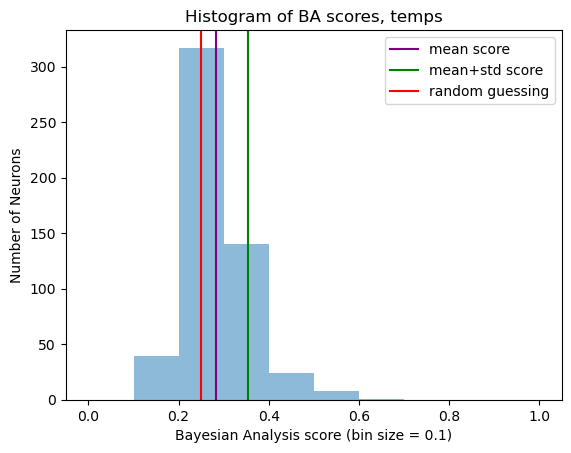

In [157]:
bin_loc = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
plt.hist(neuron_vs_score[:,1], bins=bin_loc, density=False, alpha=0.5)
plt.axvline(x=np.mean(neuron_vs_score[:,1]),color='purple', label='mean score')
plt.axvline(x=(np.mean(neuron_vs_score[:,1]) + abs(np.std(neuron_vs_score[:,1]))),color='green', label='mean+std score')
plt.axvline(x=0.25,color='red', label='random guessing')
plt.title("Histogram of BA scores, temps")
plt.legend(loc='upper right')
plt.ylabel('Number of Neurons')
plt.xlabel('Bayesian Analysis score (bin size = 0.1)')
plt.show()